In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from __future__ import print_function

import hosts
import targeting
import mmthecto
import numpy as np

from astropy import units as u
from astropy.coordinates import *
from astropy import table
from astropy.table import Table
from astropy.io import fits

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)

In [4]:
hostlst = hosts.get_saga_hosts_from_google() #'named' hosts

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [5]:
candidates = """
NSAID    RA   DEC Name
   150887      23.2455      4.53406  N/A
    150578.      23.0824      12.3229  N/A
    149781.      22.3942     -3.43167  OBrother
    150307.      22.9283     -5.49535  N/A
    61945.0      23.6087     0.297265  AnaK
    149977.      22.6248      10.5315  N/A
    153017.      23.9904      20.7498  N/A
    126115.    0.0663717      20.7524  N/A
    127226.     0.579656     -8.39644  N/A
    129387.      1.40109      12.9175  N/A
    129237.      1.36327      17.5922  N/A
    132339.      2.63655     -1.31876 Narnia
    130133.      1.65181     -7.51266  N/A
    131531.      2.25767      6.00248  N/A
    130625.      1.88703      4.19576  N/A
"""
candidates = Table.read(candidates,format='ascii')

hostdct = dict([(h.name, h) for h in hostlst])
candhosts = [hostdct[name] if name in hostdct else hosts.NSAHost(int(nsaid)) 
         for nsaid, name in zip(candidates['NSAID'], candidates['Name'])]
candhosts

[<hosts.NSAHost object w/ name 'NSA150887'>,
 <hosts.NSAHost object w/ name 'NSA150578'>,
 <hosts.NSAHost object w/ name 'OBrother' AKA: ['NSA149781']>,
 <hosts.NSAHost object w/ name 'NSA150307'>,
 <hosts.NSAHost object w/ name 'AnaK' AKA: ['NGC7716', 'NSA61945']>,
 <hosts.NSAHost object w/ name 'NSA149977'>,
 <hosts.NSAHost object w/ name 'NSA153017'>,
 <hosts.NSAHost object w/ name 'NSA126115'>,
 <hosts.NSAHost object w/ name 'NSA127226'>,
 <hosts.NSAHost object w/ name 'NSA129387'>,
 <hosts.NSAHost object w/ name 'NSA129237'>,
 <hosts.NSAHost object w/ name 'Narnia' AKA: ['NGC1015', 'NSA132339']>,
 <hosts.NSAHost object w/ name 'NSA130133'>,
 <hosts.NSAHost object w/ name 'NSA131531'>,
 <hosts.NSAHost object w/ name 'NSA130625'>]

In [6]:
# now set to the latest base catalogs
for h in candhosts:
    h.fnsdss = 'catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None

In [7]:
# actually make sure they're loaded here
for h in candhosts:
    h.get_sdss_catalog()
h.get_sdss_catalog() # just to see

objID,ra,dec,flags,specObjID,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,Au,Ag,Ar,Ai,Az,fibermag_r,fiber2mag_r,expRad_r,sb_exp_r,petroR50_r,petroR90_r,petroMag_r,sb_petro_r,J,Jerr,H,Herr,K,Kerr,w1,w1err,w2,w2err,spec_z,spec_z_err,spec_z_warn,photoz,photoz_err,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,PCLASS_1,SATS,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_REPEAT,U,B,V,R,I,rhost,rhost_kpc,type,phot_sg
int64,float64,float64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,int64,int64,string384,float64,float64,int64,int64,int64,int64,string32,string384,float64,string384,float32,float32,float32,float32,float32,float64,float64,int16,string48
1237678622239687293,28.2921893761,4.1654677952,387097114444048,0,24.8861,24.5384,22.9648,21.9456,21.3148,0.966116,0.565863,0.238203,0.135154,0.280791,0.19371,0.14253,0.103375,0.0783858,0.0555765,22.261,22.9741,0.132225,20.5668021324,0.641864,1.37584,22.9859,24.0185837122,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,17.9499,0.207252,16.003,0.175,-1.0,-1.0,-1,0.595791,0.082322,28.3054,4.19576,22.7469,1733.0,8.726,130625,0,,1.98200266096,13.114524378,-1,-1,-1,-1,,,-1.0,,25.4448,25.2499,23.6333,22.6919,21.3051,0.0330198482762,12.9620185552,3,GALAXY
1237678622239687535,28.2808531784,4.17348908215,281543964623616,0,24.2549,23.1379,21.9114,21.7858,21.6071,0.975535,0.212821,0.0979778,0.120167,0.359127,0.193723,0.142539,0.103381,0.078391,0.0555802,22.2951,22.7768,0.216964,20.5887781366,0.590522,1.3195,22.0478,22.8994797037,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,19.4984,0.848584,9999.0,9999.0,-1.0,-1.0,-1,-1.0,-1.0,28.3054,4.19576,22.7469,1733.0,8.726,130625,0,,1.98573241428,13.1392034243,-1,-1,-1,-1,,,-1.0,,24.1516,23.7408,22.4289,21.7752,21.3198,0.0330706320147,12.9819538303,6,STAR
1237678622239687551,28.2892305507,4.1666156998,281543964623104,0,23.538,23.6733,22.7989,22.2601,21.7235,0.647714,0.320625,0.201627,0.175092,0.371933,0.193668,0.142499,0.103352,0.078369,0.0555646,22.9504,23.4056,0.00149116,10.6619883934,-9999.0,-9999.0,27.0005,48.9956979059,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,17.5289,0.137348,9999.0,9999.0,-1.0,-1.0,-1,0.637883,0.137668,28.3054,4.19576,22.7469,1733.0,8.726,130625,0,,1.99849702866,13.2236643743,-1,-1,-1,-1,,,-1.0,,23.739,24.1659,23.1633,22.5995,21.656,0.0332919091918,13.0688167029,3,GALAXY
1237678661436375815,28.3178710528,4.22726178032,281543964623616,0,26.1572,22.1578,21.4868,20.0189,19.5865,1.65004,0.2729,0.266116,0.109058,0.29841,0.196014,0.144225,0.104604,0.079318,0.0562375,23.1452,23.5192,0.264709,21.7103790809,3.99238,6.47142,21.4839,26.4855161938,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,18.7934,0.469792,9999.0,9999.0,-1.0,-1.0,-1,0.9529,0.184473,28.3054,4.19576,22.7469,1733.0,8.726,130625,0,,2.03209360161,13.4459663078,-1,-1,-1,-1,,,-1.0,,24.2021,22.5868,21.7627,21.1452,19.455,0.0338807234169,13.2999571021,3,GALAXY
1237678661436375822,28.3379290684,4.18852269949,281475245277440,0,23.64,23.186,23.3671,21.5564,21.3618,0.947116,0.258817,0.522418,0.157588,0.518212,0.195576,0.143903,0.10437,0.079141,0.0561119,23.8665,24.1587,4.25089,27.4210324564,0.841304,1.10107,23.5624,25.1826394487,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,17.6542,0.157534,9999.0,9999.0,-1.0,-1.0,-1,0.465791,0.248365,28.3054,4.19576,22.7469,1733.0,8.726,130625,0,,1.99436115266,13.1962980939,-1,-1,-1,-1,,,-1.0,,22.6684,23.3483,23.2723,22.973,21.0843,0.0332725715253,13.0612256568,3,GALAXY
1237678622239687292,28.2917688682,4.16479395685,35253360001296,0,24.8854,22.4322,20.8396,20.1583,19.794,1.14023,0.136569,0.0478744,0.0372707,0.0961961,0.193663,0.142496,0.10335,0.0783669,0.0555631,21.3316,21.8734,0.49728,21.3671699956,0.739849,1.4289,20.

In [8]:
mlpred = Table.read('catalogs/SAGA.ALL.objid_rescaledrobs_pred.Oct28_SDSS_nopreclean.csv.fits.gz')
mlpred['objID'] = mlpred['OBJID'] # used for matching
mlpred

OBJID,RA,DEC,DERED_R,PROBABILITY_CLASS_1,RESCALED_PROBABILITY_CLASS_1,BEST_GUESS_CLASS,objID
int64,float64,float64,float64,float64,float64,int64,int64
1237645941824356440,40.2877964113,-0.735647060949,16.7594,0.00157168316197,0.000345859198981,0,1237645941824356440
1237645941824356442,40.2745834514,-0.733014063478,17.4514,0.000372493836691,8.19307625291e-05,0,1237645941824356442
1237645941824356481,40.2721052363,-0.642510253204,16.7911,0.00178514575454,0.000358794024809,0,1237645941824356481
1237645941824356483,40.2712777717,-0.640725293001,20.9894,0.000240454811286,5.13915737065e-05,0,1237645941824356483
1237645941824356484,40.2783697699,-0.641212507445,21.2884,0.000270864809902,5.63874521068e-05,0,1237645941824356484
1237645941824356485,40.2826647047,-0.642892947061,22.4926,3.61806080935e-05,0.0,0,1237645941824356485
1237645941824356497,40.2846730128,-0.817180215799,14.8628,0.000363130559728,8.19307625291e-05,0,1237645941824356497
1237645941824356500,40.2881452154,-0.805045508948,14.3826,0.000488674982738,8.85746681048e-05,0,1237645941824356500
1237645941824356501,40.2854134086,-0.804100473432,20.2454,0.000763301466982,0.000162326503484,0,1237645941824356501


In [9]:
p_column_for_ranking = 'PROBABILITY_CLASS_1' #this is *just* SDSS

# Testing w/ NSA 150887

In [9]:
n150887 = candhosts[0]
hosts_to_target = [n150887]

In [12]:
joined_catalogs = {}
for h in hosts_to_target:
    #filter on manual remove lists *and* REMOVE!=-1
    cat = targeting.remove_targets_with_remlist(h.get_sdss_catalog(), h, 'catalogs/TargetRemoveAug28_2015.csv')
    
    pre_joined = table.join(cat, mlpred, join_type='left', keys='objID')
    
    tokeep = pre_joined['REMOVE']==-1
    notobserved = pre_joined['ZQUALITY']<3
    print('removed', np.sum(~tokeep),'for remove list and', np.sum(~notobserved),'b/c observed')
    joined_catalogs[h] = pre_joined[tokeep&notobserved]
    highp = pre_joined[p_column_for_ranking]>0.01
    print('n w/ ML pred>0.01 and observed:', np.sum(highp&~notobserved), 'not yet obs:', np.sum(highp&notobserved))

Removed 4 objects for NSA150887
removed 250 for remove list and 722 b/c observed
n w/ ML pred>0.01 and observed: 7 not yet obs: 506


## No redmapper 

In [13]:
# compute ranks, which includes filtering on mag
rankdct = {}
for h in hosts_to_target:
    cat = joined_catalogs[h]
    
    highprob = cat[p_column_for_ranking].filled(0) > 0.5
    medprob = (cat[p_column_for_ranking].filled(0) > 0.05) & ~highprob
    lowprob = (cat[p_column_for_ranking].filled(0) > 0.01) & ~highprob & ~medprob
    inside = cat['RHOST_KPC']<300
    
    rankdct[h] = ranks = np.ones(len(cat), dtype=int)*-1 #the -1 will be re-set at the end
    
    # rank 1 reserved for flux stars
    ranks[inside&highprob] = 2
    ranks[~inside&highprob] = 3
    ranks[inside&medprob] = 4
    ranks[~inside&medprob] = 5
    ranks[inside&lowprob] = 6
    ranks[~inside&lowprob] = 7
    
    validtarget = (cat['r'] < 21.5) & (cat['fibermag_r']<23) & (cat['phot_sg']=='GALAXY')
    other = ranks < 0
    colorcutmsk = targeting.colorcut_mask(cat,  targeting.bossanova_color_cuts)
    
    ranks[validtarget&other&colorcutmsk] = 8
    ranks[validtarget&other&~colorcutmsk] = 9
    
#informational
for h, ranks in rankdct.items():
    cat = joined_catalogs[h]
    
    hranks = dict(enumerate(np.bincount(ranks[ranks>-1])))
    del hranks[0]
    del hranks[1]
    hranks[-1] = np.sum(ranks==-1)
    
    print(h.name,'rank counts:', hranks)
    
    nother =  np.sum(ranks==8)
    nprob = np.sum((ranks<8)&(ranks>0))
    nother_obs = 270-np.sum((ranks<8)&(ranks>0)&(cat['RHOST_ARCM']<30))
    print('fraction not "other": {0:.1%}, nprob_obs={1}\n'.format(nprob/(nprob+nother), nother_obs))

NSA150887 rank counts: {2: 3, 3: 3, 4: 52, 5: 84, 6: 80, 7: 251, 8: 9483, 9: 7581, -1: 51746}
fraction not "other": 4.8%, nprob_obs=120



## Sanity-checks

### are the ML-selected objects meeting the fibermag and r cuts?

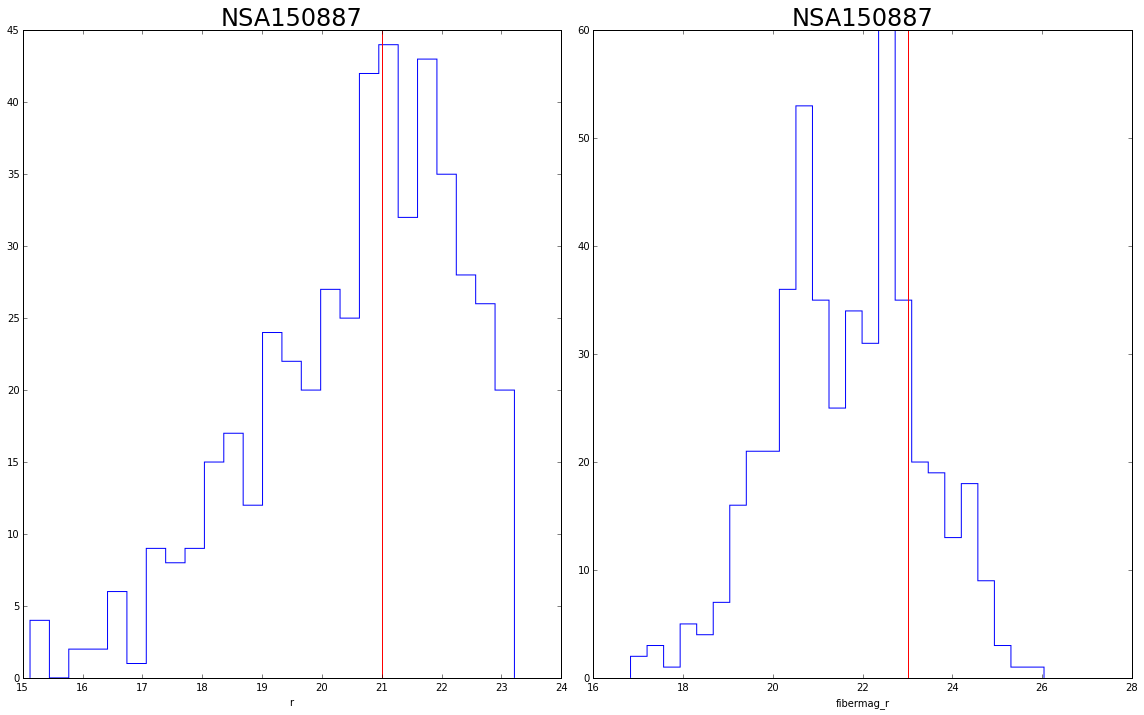

In [14]:
for h in hosts_to_target:
    cat = joined_catalogs[h]
    ranks = rankdct[h]

    plt.figure()
    
    msk = (ranks>0)&(ranks<8)
    plt.subplot(1,2,1)
    plt.hist(cat[msk]['r'],bins=25, histtype='step')
    plt.axvline(21,c='r')
    plt.xlabel('r')
    plt.title(h.name, fontsize=24)
    
    plt.subplot(1,2,2)
    plt.hist(cat[msk]['fibermag_r'],bins=25, histtype='step')
    plt.axvline(23,c='r')
    plt.xlabel('fibermag_r')
    plt.title(h.name, fontsize=24)
    
    plt.tight_layout()

### Check that new ML predictions are fairly complete 

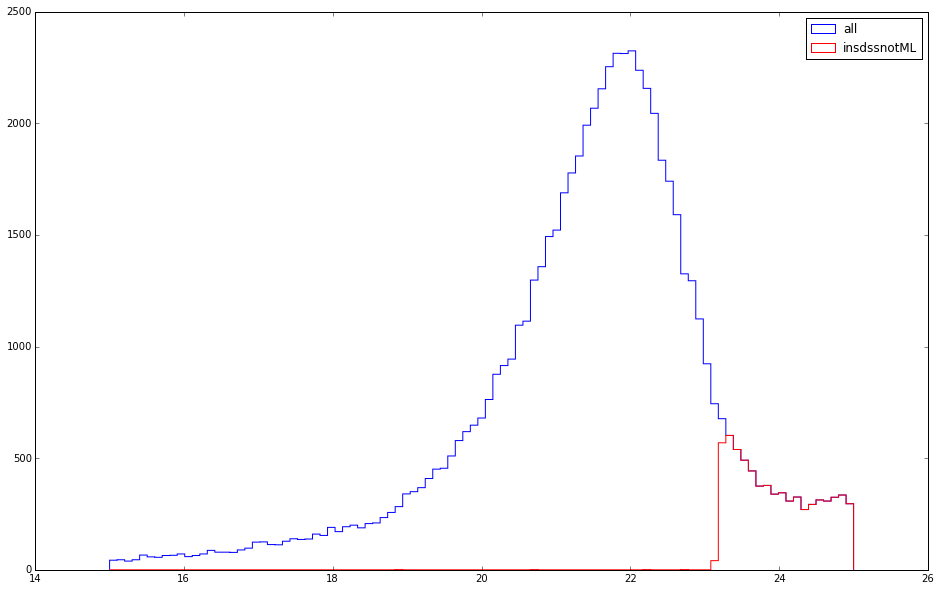

In [17]:

bins = np.linspace(15,25, 100)
notinml = cat['OBJID'].mask
plt.hist(cat['r'], color='b', bins=bins, histtype='step', label='all')
plt.hist(cat['r'][notinml], color='r', bins=bins, histtype='step', label='insdssnotML')
plt.legend(loc=0)
None

### check compared to the *old* mlpred file

In [18]:
mlpred_old = Table.read('catalogs/SAGAobjid_PredictionAug28_SDSS_SDSSwise_v4removed_combinedPs.fits.gz')
mlpred_old['OBJID'].name = 'objID'

In [19]:
# 
joined_catalogs_old = {}
for h in hosts_to_target:
    #filter on manual remove lists *and* REMOVE!=-1
    cat = targeting.remove_targets_with_remlist(h.get_sdss_catalog(), h, 'catalogs/TargetRemoveAug28_2015.csv')
    
    pre_joined = table.join(cat, mlpred_old, join_type='left', keys='objID')
    
    tokeep = pre_joined['REMOVE']==-1
    notobserved = pre_joined['ZQUALITY']<3
    print('removed', np.sum(~tokeep),'for remove list and', np.sum(~notobserved),'b/c observed')
    joined_catalogs_old[h] = pre_joined[tokeep&notobserved]
    highp = pre_joined[p_column_for_ranking]>0.01
    print('n w/ ML pred>0.01 and observed:', np.sum(highp&~notobserved), 'not yet obs:', np.sum(highp&notobserved))

Removed 4 objects for NSA150887
removed 250 for remove list and 722 b/c observed
n w/ ML pred>0.01 and observed: 0 not yet obs: 124


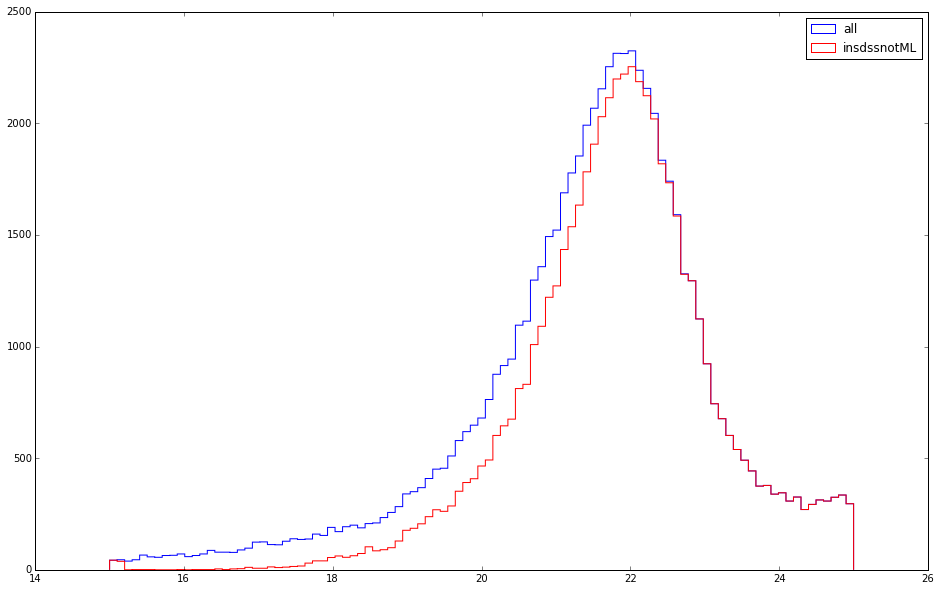

In [20]:
cat = joined_catalogs_old[n150887]
bins = np.linspace(15,25, 100)
notinml = cat['PROBABILITY_CLASS_1'].mask
plt.hist(cat['r'], color='b', bins=bins, histtype='step', label='all')
plt.hist(cat['r'][notinml], color='r', bins=bins, histtype='step', label='insdssnotML')
plt.legend(loc=0)
None

## Now actually generate a catalog 

In [22]:
generated_cats = {}
for h in hosts_to_target:
    print('On host', h.name)
    sys.stdout.flush()

    cat = joined_catalogs[h]
    ranks = rankdct[h]
    
    fnout = 'mmthecto/{0}_nov2015.cat'.format(h.name)
    fluxfnout = fnout.replace('.cat', '.fluxstars')
    print('Going to write', fnout)
    
    msk = (cat['RHOST_ARCM']<40) & (ranks>0) & (ranks<9)
    generated_cats[h] = mmthecto.generate_catalog(h, cat[msk], ranks[msk], 
                                         repeatflux=3, removefluxdistance=1*u.arcmin,
                                         fnout=fnout, fluxfnout=fluxfnout)

On host NSA150887
Going to write mmthecto/NSA150887_nov2015.cat
Including 4503 targets
Found 73 Flux stars
Removing 34 Flux stars too close to program stars
Could not find psf mags so falling back on regular mags...
Found 255 guide stars


### Have a look at the  input catalog

In [68]:
gcat = generated_cats[h]

In [77]:
ranknum = gcat['rank'].copy()
ranknum[gcat['rank']==''] = '-1'
ranknum = ranknum.astype(int)
{r: np.sum(r==ranknum) for r in set(ranknum)}

{-1: 255, 1: 117, 2: 3, 4: 52, 5: 14, 6: 80, 7: 79, 8: 4275}

In [122]:
msk = (ranknum>1)&(ranknum<6)
gcatm = gcat[msk]
targeting.sampled_imagelist(gcatm[np.argsort(gcatm['ra'])], None, None, names=gcat['rank'][msk])
None

In [155]:
#identify clumps of nearby objects
gcatmsc = SkyCoord(gcatm['ra'], gcatm['dec'], unit=u.deg)
seps = u.Quantity([c.separation(gcatmsc) for c in gcatmsc])

pairs = zip(*np.where((seps>0.1*u.arcsec)&(seps<10*u.arcsec)))
pairs = [pair for pair in pairs if pair[0]<pair[1]]

clumps = []
for p1, p2 in pairs:
    for clump in clumps:
        if p1 in clump:
            clump.append(p2)
            break
        elif p2 in clump:
            clump.append(p1)
            break
    else:
        clumps.append([p1, p2])
for cl in clumps:
    targeting.sampled_imagelist(gcatm[np.array(cl)], None, None, names=cl)
clumps

[[5, 6, 7],
 [18, 20],
 [24, 25, 28, 27],
 [33, 34, 35, 35],
 [46, 47, 48],
 [49, 50],
 [51, 52],
 [58, 59],
 [65, 66]]

In [161]:
np.sum(joined_catalogs[n150887]['objID']==long(1237678777399509169))

1

In [163]:
cat = joined_catalogs[n150887]
clumpcats = []
for clump in clumps:
    msk = np.zeros(len(cat), dtype=bool)
    for c in clump:
        msk[cat['objID']==long(gcatm[c]['object'])] = True
    clumpcats.append(cat[msk])
clumpcats[0]

objID,ra,dec,flags,specObjID,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,Au,Ag,Ar,Ai,Az,fibermag_r,fiber2mag_r,expRad_r,sb_exp_r,petroR50_r,petroR90_r,petroMag_r,sb_petro_r,J,Jerr,H,Herr,K,Kerr,w1,w1err,w2,w2err,spec_z,spec_z_err,spec_z_warn,photoz,photoz_err,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,PCLASS_1,SATS,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_REPEAT,U,B,V,R,I,rhost,rhost_kpc,type,phot_sg,OBJID,RA,DEC,DERED_R,PROBABILITY_CLASS_1,RESCALED_PROBABILITY_CLASS_1,BEST_GUESS_CLASS
int64,float64,float64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,int64,int64,string384,float64,float64,int64,int64,int64,int64,string32,string384,float64,string384,float32,float32,float32,float32,float32,float64,float64,int16,string48,int64,float64,float64,float64,float64,float64,int64
1237678777399509169,348.875470715,4.61463399851,35253360136976,0,17.9521,16.8473,16.4473,16.1783,16.0934,0.0625012,0.00996324,0.0118409,0.0145512,0.0544884,0.369924,0.272186,0.197412,0.149692,0.106133,19.9074,20.4247,14.4644,24.244265902,11.129,21.928,16.5673,23.7950578723,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,14.6228,0.0908054,9999.0,9999.0,-1.0,-1.0,-1,0.056739,0.019698,348.683,4.53406,37.019,2689.0,8.327,150887,0,,12.486005011,134.453883338,-1,-1,-1,-1,,,-1.0,,17.1581,17.1916,16.6053,16.2892,15.7485,0.208173896381,133.338436792,3,GALAXY,1237678777399509169,348.875470715,4.61463399851,16.2499,0.473888691928,0.505488139871,0
1237678777399509170,348.874199097,4.61326147472,1231558551928920,0,22.3159,20.6245,20.0919,19.8157,19.8534,0.392078,0.0384179,0.0380788,0.0441104,0.174327,0.36957,0.271926,0.197224,0.149549,0.106032,20.33,21.1625,0.91242,21.8883004344,1.14993,1.76627,20.2737,22.5725191946,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,16.1166,0.0458888,15.574,0.149,-1.0,-1.0,-1,0.052225,0.046889,348.683,4.53406,37.019,2689.0,8.327,150887,0,,12.3840809333,133.356332238,-1,-1,-1,-1,,,-1.0,,21.352,21.0102,20.3076,19.9326,19.4333,0.206475522261,132.250603235,3,GALAXY,1237678777399509170,348.874199097,4.61326147472,19.8947,0.0891206695302,0.0631252166206,0
1237678777399509175,348.873312422,4.61612028637,246290906743128,0,22.9129,21.6294,21.566,22.7656,22.9657,0.575839,0.078098,0.121213,0.515372,1.13875,0.369564,0.271922,0.19722,0.149546,0.10603,21.8345,22.4355,0.493071,22.0445243717,1.08031,2.03902,21.6577,23.8208900224,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,17.6124,0.181179,9999.0,9999.0,-1.0,-1.0,-1,0.060248,0.040626,348.683,4.53406,37.019,2689.0,8.327,150887,0,,12.4022149121,133.551604736,-1,-1,-1,-1,,,-1.0,,21.7492,21.8682,21.5776,21.6325,22.4458,0.206776961875,132.443679733,3,GALAXY,1237678777399509175,348.873312422,4.61612028637,21.3688,0.0984644726791,0.0739143669066,0


In [167]:
clumped = []
for clump in clumps:
    for i in clump:
        clumped.append(i)
        
nmult = len(clumped) - len(clumps)
len(gcatm), len(clumped), nmult, len(clumped)/len(gcatm), nmult/len(gcatm)

(69, 24, 15, 0.34782608695652173, 0.21739130434782608)

### Have a looksee at the configuration output by xfitfibs 

In [63]:
coords, targets, ranks, fields = mmthecto.parse_cfg_file('mmthecto/NSA150887_nov2015.cfg')

In [65]:
msk = ranks == 2
targeting.sampled_imagelist(coords[msk], None, None, names=targets[msk])

'name ra dec\n1277 348.696642083 4.639955\n2945 348.394260417 4.55277194444\n1278 348.727540833 4.71334444444'

# Production run

In [39]:
hostnames_to_target = [150887, 150578, 'OBrother', 150307, 'AnaK', 149977, 153017, 129387, 129237, 'Narnia', 126115]
hosts_to_target = []
for hostname in hostnames_to_target:
    if isinstance(hostname, basestring):
        for host in candhosts:
            if host.name == hostname:
                hosts_to_target.append(host)
                break
        else:
            raise ValueError('could not find host named {0}'.format(hostname))
    else:
        for host in candhosts:
            if host.nsaid == hostname:
                hosts_to_target.append(host)
                break                
        else:
            raise ValueError('could not find host with nsa number {0}'.format(hostname))
hosts_to_target

[<hosts.NSAHost object w/ name 'NSA150887'>,
 <hosts.NSAHost object w/ name 'NSA150578'>,
 <hosts.NSAHost object w/ name 'OBrother' AKA: ['NSA149781']>,
 <hosts.NSAHost object w/ name 'NSA150307'>,
 <hosts.NSAHost object w/ name 'AnaK' AKA: ['NGC7716', 'NSA61945']>,
 <hosts.NSAHost object w/ name 'NSA149977'>,
 <hosts.NSAHost object w/ name 'NSA153017'>,
 <hosts.NSAHost object w/ name 'NSA129387'>,
 <hosts.NSAHost object w/ name 'NSA129237'>,
 <hosts.NSAHost object w/ name 'Narnia' AKA: ['NGC1015', 'NSA132339']>,
 <hosts.NSAHost object w/ name 'NSA126115'>]

In [40]:
joined_catalogs = {}
for h in hosts_to_target:
    #filter on manual remove lists *and* REMOVE!=-1
    #cat = targeting.remove_targets_with_remlist(h.get_sdss_catalog(), h, 'catalogs/TargetRemoveNov8_2015.csv')
    cat = targeting.remove_targets_with_remlist(h.get_sdss_catalog(), h, 'catalogs/TargetRemoveNov11_2015.csv')
    
    pre_joined = table.join(cat, mlpred, join_type='left', keys='objID')
    
    tokeep = pre_joined['REMOVE']==-1
    notobserved = pre_joined['ZQUALITY']<3
    print('removed', np.sum(~tokeep),'for remove list and', np.sum(~notobserved),'b/c observed')
    joined_catalogs[h] = pre_joined[tokeep&notobserved]
    highp = pre_joined[p_column_for_ranking]>0.01
    print('n w/ ML pred>0.01 and observed:', np.sum(highp&~notobserved), 'not yet obs:', np.sum(highp&notobserved))

Removed 36 objects for NSA150887
removed 250 for remove list and 722 b/c observed
n w/ ML pred>0.01 and observed: 7 not yet obs: 474
Removed 9 objects for NSA150578
removed 58 for remove list and 47 b/c observed
n w/ ML pred>0.01 and observed: 6 not yet obs: 702
Removed 12 objects for OBrother
removed 280 for remove list and 411 b/c observed
n w/ ML pred>0.01 and observed: 14 not yet obs: 723
Removed 20 objects for NSA150307
removed 80 for remove list and 2 b/c observed
n w/ ML pred>0.01 and observed: 1 not yet obs: 355
Removed 38 objects for AnaK
removed 479 for remove list and 2060 b/c observed
n w/ ML pred>0.01 and observed: 72 not yet obs: 778
Removed 11 objects for NSA149977
removed 52 for remove list and 225 b/c observed
n w/ ML pred>0.01 and observed: 5 not yet obs: 505
Removed 24 objects for NSA153017
removed 89 for remove list and 3 b/c observed
n w/ ML pred>0.01 and observed: 2 not yet obs: 447
Removed 21 objects for NSA129387
removed 282 for remove list and 317 b/c observed


### Includes Redmapper 

In [41]:
redmappertargs = table.Table.read('catalogs/redmagic_targets_0828.fit')
redmappertargs

OBJID,RA,DEC,RMAG
int64,float64,float64,float32
1237678776862507491,348.579777605,4.32783514044,19.8827
1237678776862507396,348.524872272,4.37104962664,20.2401
1237679005021766016,348.408632143,4.48647461874,20.4682
1237679005021766095,348.434188695,4.51415572616,20.0641
1237679005021766194,348.467962826,4.51723020806,19.6637
1237678776862441902,348.375664902,4.30292498984,20.5198
1237679005021700367,348.345592087,4.4104833109,18.9509
1237679005021701029,348.392077147,4.43849219143,19.3736
1237679005021765999,348.407858965,4.41972791471,19.4642


In [42]:
# compute ranks, which includes filtering on mag
rankdct = {}
for h in hosts_to_target:
    cat = joined_catalogs[h]
    
    highprob = cat[p_column_for_ranking].filled(0) > 0.5
    medprob = (cat[p_column_for_ranking].filled(0) > 0.05) & ~highprob
    lowprob = (cat[p_column_for_ranking].filled(0) > 0.01) & ~highprob & ~medprob
    inside = cat['RHOST_KPC']<300
    
    rankdct[h] = ranks = np.ones(len(cat), dtype=int)*-1 #the -1 will be re-set at the end
    
    # rank 1 reserved for flux stars
    ranks[inside&highprob] = 2
    ranks[~inside&highprob] = 3
    ranks[inside&medprob] = 4
    ranks[~inside&medprob] = 5
    ranks[inside&lowprob] = 6
    ranks[~inside&lowprob] = 7
    
    validtarget = (cat['r'] < 21.5) & (cat['fibermag_r']<23) & (cat['phot_sg']=='GALAXY')
    other = ranks < 0
    colorcutmsk = targeting.colorcut_mask(cat,  targeting.bossanova_color_cuts)
    
    ranks[validtarget&other&colorcutmsk] = 9 #other incl. color cuts
    ranks[validtarget&other&~colorcutmsk] = 10 #other not incl. color cuts
    redmappertarg = np.in1d(cat['objID'], redmappertargs['OBJID'])
    rg7 = ranks>7
    ranks[validtarget&redmappertarg&rg7] = 8 #redmapper
    
#informational
for h, ranks in rankdct.items():
    cat = joined_catalogs[h]
    
    hranks = dict(enumerate(np.bincount(ranks[ranks>-1])))
    del hranks[0]
    del hranks[1]
    hranks[-1] = np.sum(ranks==-1)
    
    print(h.name,'rank counts:', hranks)
    
    nother =  np.sum(ranks==8)
    nprob = np.sum((ranks<8)&(ranks>0))
    nother_obs = 270-np.sum((ranks<8)&(ranks>0)&(cat['RHOST_ARCM']<30))
    print('fraction not "other": {0:.1%}, nprob_obs={1}\n'.format(nprob/(nprob+nother), nother_obs))

NSA129237 rank counts: {2: 1, 3: 5, 4: 62, 5: 273, 6: 108, 7: 494, 8: 35, 9: 6879, 10: 4764, -1: 45505}
fraction not "other": 96.4%, nprob_obs=56

NSA126115 rank counts: {2: 0, 3: 0, 4: 27, 5: 94, 6: 73, 7: 240, 8: 62, 9: 8320, 10: 5905, -1: 42900}
fraction not "other": 87.5%, nprob_obs=185

NSA150307 rank counts: {2: 0, 3: 3, 4: 16, 5: 58, 6: 50, 7: 210, 8: 24, 9: 8229, 10: 5351, -1: 42612}
fraction not "other": 93.4%, nprob_obs=184

AnaK rank counts: {2: 0, 3: 1, 4: 33, 5: 171, 6: 127, 7: 433, 8: 75, 9: 9868, 10: 5341, -1: 60359}
fraction not "other": 91.1%, nprob_obs=106

NSA153017 rank counts: {2: 0, 3: 0, 4: 44, 5: 38, 6: 191, 7: 165, 8: 66, 9: 9011, 10: 6426, -1: 46178}
fraction not "other": 86.9%, nprob_obs=191

NSA129387 rank counts: {2: 0, 3: 2, 4: 36, 5: 105, 6: 96, 7: 346, 8: 49, 9: 10017, 10: 6065, -1: 53318}
fraction not "other": 92.3%, nprob_obs=108

Narnia rank counts: {2: 0, 3: 2, 4: 39, 5: 180, 6: 66, 7: 443, 8: 63, 9: 10738, 10: 5803, -1: 56191}
fraction not "other": 

## Visual Removal of shreds 

In [28]:
def clump_finder(sc, clumpsep=10*u.arcsec):
    """
    Find clumps within a certain distance in a SkyCoord catalog
    """
    sc1 = SkyCoord(sc.ra.reshape(1, len(sc)), sc.dec.reshape(1, len(sc)))
    sc2 = SkyCoord(sc.ra.reshape(len(sc), 1), sc.dec.reshape(len(sc), 1))
    seps = sc1.separation(sc2)
    #seps = u.Quantity([c.separation(sc) for c in sc])

    pairs = zip(*np.where((seps>0.1*u.arcsec)&(seps<clumpsep)))
    pairs = [pair for pair in pairs if pair[0]<pair[1]]

    clumps = []
    for p1, p2 in pairs:
        for clump in clumps:
            if p1 in clump:
                clump.append(p2)
                break
            elif p2 in clump:
                clump.append(p1)
                break
        else:
            clumps.append([p1, p2])
    return clumps

clumpdct = {}
for h in hosts_to_target:
    cat = joined_catalogs[h]
    ranks = rankdct[h]
    
    #msk = (1<ranks)&(ranks<8)
    msk = (ranks==2)|(ranks==4)|(ranks==6)
    
    catm = cat[msk]
    highp_scs = SkyCoord(catm['ra'], catm['dec'], unit=u.deg)
    clumpdct[h] = (clump_finder(highp_scs), msk)

In [30]:
#now we go through each and show the clumps 
for h in hosts_to_target:
    cat = joined_catalogs[h]
    clumps, clumpmsk = clumpdct[h]
    
    clumpnum = []
    clumpra = []
    clumpdec = []
    clumpobjid = []
    for i, c in enumerate(clumps):
        print('Clump#', i)
        for idx in c:
            clumpnum.append(i)
            clumpra.append(cat[clumpmsk][idx]['ra'])
            clumpdec.append(cat[clumpmsk][idx]['dec'])
            clumpobjid.append(cat[clumpmsk][idx]['objID'])
            if h.name.startswith('NSA'):
                nmstr = ''
            else:
                nmstr = h.name
            print('{0}\t{1}\t{2}\t{3}\t{4}\t{5}'.format(nmstr, h.nsaid, clumpobjid[-1], clumpra[-1], clumpdec[-1],'shred galaxy <semiauto-found>'))
            
        
    targeting.sampled_imagelist(clumpra, clumpdec, n=np.inf, names=clumpnum)
        
    res = raw_input('{} <enter to continue>'.format(h.name, h.nsaid))
    if res == 'x':
        break

NSA150887 <enter to continue>
NSA150578 <enter to continue>
OBrother <enter to continue>
NSA150307 <enter to continue>
Clump# 0
AnaK	61945	1237663277925335666	354.474453404	0.598619137594	shred galaxy <semiauto-found>
AnaK	61945	1237663277925335668	354.473556524	0.596307668716	shred galaxy <semiauto-found>
Clump# 1
AnaK	61945	1237663277925335849	354.526252686	0.536511405586	shred galaxy <semiauto-found>
AnaK	61945	1237663277925335850	354.527253118	0.533963323664	shred galaxy <semiauto-found>
AnaK <enter to continue>
NSA149977 <enter to continue>
Clump# 0
	153017	1237679504318857846	359.881179224	20.4716167358	shred galaxy <semiauto-found>
	153017	1237679504318857848	359.8815262	20.4690042853	shred galaxy <semiauto-found>
NSA153017 <enter to continue>
Clump# 0
	129387	1237678860091261057	21.1199772173	12.7913912476	shred galaxy <semiauto-found>
	129387	1237678860091261058	21.1193197583	12.7935316946	shred galaxy <semiauto-found>
NSA129387 <enter to continue>
Clump# 0
	129237	12376791693

### Keeping output of old version used to make rem list 

In [61]:
#now we go through each and show the clumps 
#NOTE: the output should now be much smaller because the rem list is update
for h in hosts_to_target:
    cat = joined_catalogs[h]
    clumps, clumpmsk = clumpdct[h]
    
    clumpnum = []
    clumpra = []
    clumpdec = []
    clumpobjid = []
    for i, c in enumerate(clumps):
        print('Clump#', i)
        for idx in c:
            clumpnum.append(i)
            clumpra.append(cat[clumpmsk][idx]['ra'])
            clumpdec.append(cat[clumpmsk][idx]['dec'])
            clumpobjid.append(cat[clumpmsk][idx]['objID'])
            if h.name.startswith('NSA'):
                nmstr = ''
            else:
                nmstr = h.name
            print('{0}\t{1}\t{2}\t{3}\t{4}\t{5}'.format(nmstr, h.nsaid, clumpobjid[-1], clumpra[-1], clumpdec[-1],'shred galaxy <semiauto-found>'))
            
        
    targeting.sampled_imagelist(clumpra, clumpdec, n=np.inf, names=clumpnum)
        
    res = raw_input('{} <enter to continue>'.format(h.name, h.nsaid))
    if res == 'x':
        break

Clump# 0
	150887	1237678777399509169	348.875470715	4.61463399851	shred galaxy <semiauto-found>
	150887	1237678777399509170	348.874199097	4.61326147472	shred galaxy <semiauto-found>
	150887	1237678777399509171	348.874889667	4.61299644629	shred galaxy <semiauto-found>
	150887	1237678777399509175	348.873312422	4.61612028637	shred galaxy <semiauto-found>
	150887	1237678777399509177	348.875624665	4.61270778777	shred galaxy <semiauto-found>
	150887	1237678777399509171	348.874889667	4.61299644629	shred galaxy <semiauto-found>
	150887	1237678777399509173	348.871772577	4.6142060337	shred galaxy <semiauto-found>
	150887	1237678777399509174	348.87255077	4.61281086443	shred galaxy <semiauto-found>
	150887	1237678777399509177	348.875624665	4.61270778777	shred galaxy <semiauto-found>
	150887	1237678777399509174	348.87255077	4.61281086443	shred galaxy <semiauto-found>
	150887	1237678777399509177	348.875624665	4.61270778777	shred galaxy <semiauto-found>
	150887	1237678777399509174	348.87255077	4.61281

## Write out the catalog 

In [43]:
generated_cats = {}
for h in hosts_to_target:
    print('On host', h.name)
    sys.stdout.flush()

    cat = joined_catalogs[h]
    ranks = rankdct[h]
    
    fnout = 'mmthecto/{0}_nov2015.cat'.format(h.name)
    fluxfnout = fnout.replace('.cat', '.fluxstars')
    print('Going to write', fnout, fluxfnout)
    msk = (cat['RHOST_ARCM']<40) & (ranks>0) & (ranks<10)
    generated_cats[h] = gcat = mmthecto.generate_catalog(h, cat[msk], ranks[msk], 
                                         repeatflux=3, removefluxdistance=20*u.arcsec,
                                         fnout=fnout, fluxfnout=fluxfnout)

On host NSA150887
Going to write mmthecto/NSA150887_nov2015.cat mmthecto/NSA150887_nov2015.fluxstars
Including 4565 targets
Found 73 Flux stars
Removing 12 Flux stars too close to program stars
Could not find psf mags so falling back on regular mags...
Found 255 guide stars
On host NSA150578
Going to write mmthecto/NSA150578_nov2015.cat mmthecto/NSA150578_nov2015.fluxstars
Including 3522 targets
Found 57 Flux stars
Removing 6 Flux stars too close to program stars
Could not find psf mags so falling back on regular mags...
Found 248 guide stars
On host OBrother
Going to write mmthecto/OBrother_nov2015.cat mmthecto/OBrother_nov2015.fluxstars
Including 4499 targets
Found 110 Flux stars
Removing 13 Flux stars too close to program stars
Could not find psf mags so falling back on regular mags...
Found 282 guide stars
On host NSA150307
Going to write mmthecto/NSA150307_nov2015.cat mmthecto/NSA150307_nov2015.fluxstars
Including 3696 targets
Found 99 Flux stars
Removing 8 Flux stars too close to

# Try to fix up 0-crossing of NSA153017  

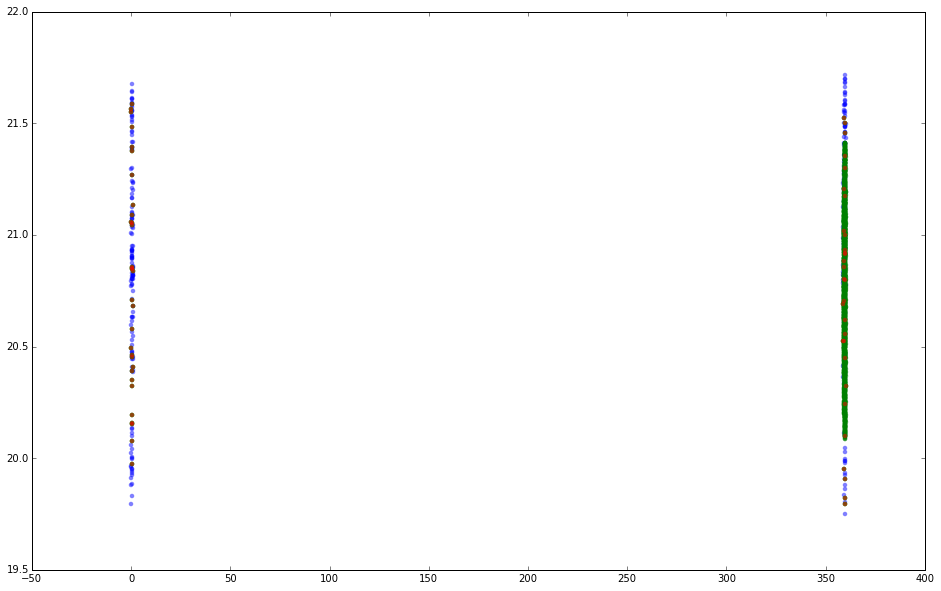

In [79]:
fncat = 'mmthecto/NSA153017_nov2015.cat'
fnflux = 'mmthecto/NSA153017_nov2015.fluxstars'

cat153017 = Table.read(fncat, format='ascii', data_start=2)
flux153017 = Table.read(fnflux, format='ascii')

catra = Angle(cat153017['ra'], u.hour).to(u.deg)
catdec = Angle(cat153017['dec'], u.deg)
fluxra = Angle(flux153017['RA'], u.deg)
fluxdec = Angle(flux153017['DEC'], u.deg)

msk = cat153017['type']=='guide'

plt.scatter(catra[msk], catdec[msk], alpha=.5,lw=0)
plt.scatter(catra[~msk], catdec[~msk], alpha=.5,lw=0, c='g')
plt.scatter(fluxra, fluxdec, alpha=.5,lw=0, c='r')

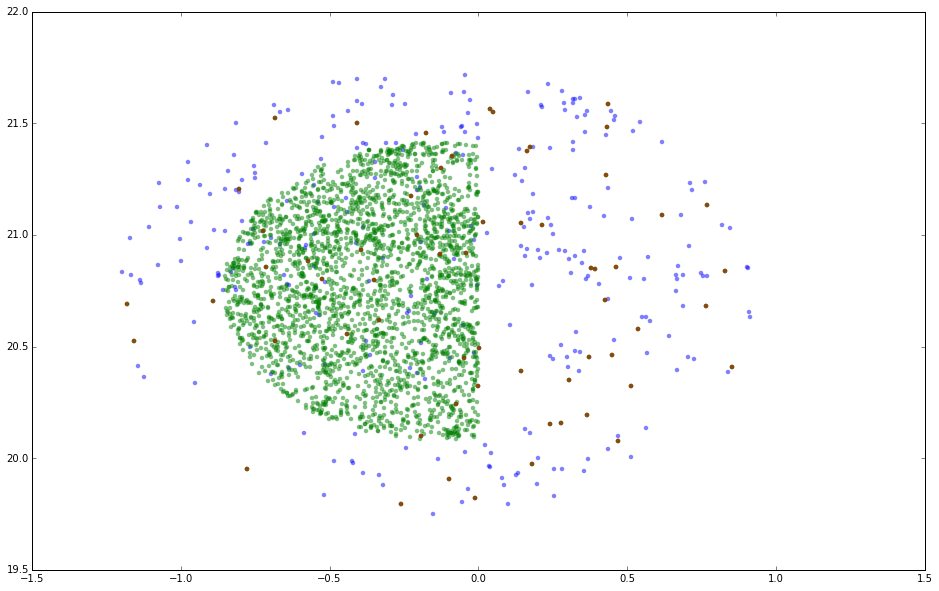

In [89]:
msk = cat153017['type']=='guide'

plt.scatter(catra[msk].wrap_at(180*u.deg), catdec[msk].wrap_at(180*u.deg), alpha=.5,lw=0)
plt.scatter(catra[~msk].wrap_at(180*u.deg), catdec[~msk].wrap_at(180*u.deg), alpha=.5,lw=0, c='g')
plt.scatter(fluxra.wrap_at(180*u.deg), fluxdec.wrap_at(180*u.deg), alpha=.5,lw=0, c='r')

Whoopsie - the problem is in RHOST_ARCM/RHOST_KPC - need to fix that up for the 0-crossing

In [93]:
hostnames_to_target = [153017]
hosts_to_target = []
for hostname in hostnames_to_target:
    if isinstance(hostname, basestring):
        for host in candhosts:
            if host.name == hostname:
                hosts_to_target.append(host)
                break
        else:
            raise ValueError('could not find host named {0}'.format(hostname))
    else:
        for host in candhosts:
            if host.nsaid == hostname:
                hosts_to_target.append(host)
                break                
        else:
            raise ValueError('could not find host with nsa number {0}'.format(hostname))
hosts_to_target

[<hosts.NSAHost object w/ name 'NSA153017'>]

In [94]:
joined_catalogs = {}
for h in hosts_to_target:
    #filter on manual remove lists *and* REMOVE!=-1
    #cat = targeting.remove_targets_with_remlist(h.get_sdss_catalog(), h, 'catalogs/TargetRemoveNov8_2015.csv')
    cat = targeting.remove_targets_with_remlist(h.get_sdss_catalog(), h, 'catalogs/TargetRemoveNov11_2015.csv')
    
    pre_joined = table.join(cat, mlpred, join_type='left', keys='objID')
    
    tokeep = pre_joined['REMOVE']==-1
    notobserved = pre_joined['ZQUALITY']<3
    print('removed', np.sum(~tokeep),'for remove list and', np.sum(~notobserved),'b/c observed')
    joined_catalogs[h] = pre_joined[tokeep&notobserved]
    highp = pre_joined[p_column_for_ranking]>0.01
    print('n w/ ML pred>0.01 and observed:', np.sum(highp&~notobserved), 'not yet obs:', np.sum(highp&notobserved))

Removed 24 objects for NSA153017
removed 89 for remove list and 3 b/c observed
n w/ ML pred>0.01 and observed: 2 not yet obs: 447


In [96]:
redmappertargs = table.Table.read('catalogs/redmagic_targets_0828.fit')

In [118]:
# compute ranks, which includes filtering on mag
rankdct = {}
for h in hosts_to_target:
    cat = joined_catalogs[h]
    
    # need to fix up distance for 0-crossing
    hc3d = SkyCoord(h.coords.ra, h.coords.dec, h.dist)
    sc = SkyCoord(cat['ra']*u.deg, cat['dec']*u.deg, distance=h.dist)
    cat['RHOST_ARCM'] = sc.separation(hc3d).to(u.arcmin).value
    cat['RHOST_KPC'] = sc.separation_3d(hc3d).to(u.kpc).value
    
    highprob = cat[p_column_for_ranking].filled(0) > 0.5
    medprob = (cat[p_column_for_ranking].filled(0) > 0.05) & ~highprob
    lowprob = (cat[p_column_for_ranking].filled(0) > 0.01) & ~highprob & ~medprob
    inside = cat['RHOST_KPC']<300
    
    rankdct[h] = ranks = np.ones(len(cat), dtype=int)*-1 #the -1 will be re-set at the end
    
    # rank 1 reserved for flux stars
    ranks[inside&highprob] = 2
    ranks[~inside&highprob] = 3
    ranks[inside&medprob] = 4
    ranks[~inside&medprob] = 5
    ranks[inside&lowprob] = 6
    ranks[~inside&lowprob] = 7
    
    validtarget = (cat['r'] < 21.5) & (cat['fibermag_r']<23) & (cat['phot_sg']=='GALAXY')
    other = ranks < 0
    colorcutmsk = targeting.colorcut_mask(cat,  targeting.bossanova_color_cuts)
    
    ranks[validtarget&other&colorcutmsk] = 9 #other incl. color cuts
    ranks[validtarget&other&~colorcutmsk] = 10 #other not incl. color cuts
    redmappertarg = np.in1d(cat['objID'], redmappertargs['OBJID'])
    rg7 = ranks>7
    ranks[validtarget&redmappertarg&rg7] = 8 #redmapper
    
#informational
for h, ranks in rankdct.items():
    cat = joined_catalogs[h]
    
    hranks = dict(enumerate(np.bincount(ranks[ranks>-1])))
    del hranks[0]
    del hranks[1]
    hranks[-1] = np.sum(ranks==-1)
    
    print(h.name,'rank counts:', hranks)
    
    nother =  np.sum(ranks==8)
    nprob = np.sum((ranks<8)&(ranks>0))
    nother_obs = 270-np.sum((ranks<8)&(ranks>0)&(cat['RHOST_ARCM']<30))
    print('fraction not "other": {0:.1%}, nprob_obs={1}\n'.format(nprob/(nprob+nother), nother_obs))

NSA153017 rank counts: {2: 0, 3: 0, 4: 23, 5: 59, 6: 91, 7: 265, 8: 66, 9: 9011, 10: 6426, -1: 46178}
fraction not "other": 86.9%, nprob_obs=158



In [130]:
reload(mmthecto)
#write out the catalog
generated_cats = {}
for h in hosts_to_target:
    print('On host', h.name)
    sys.stdout.flush()

    cat = joined_catalogs[h]
    ranks = rankdct[h]
    
    fnout = 'mmthecto/{0}_nov2015_fixed.cat'.format(h.name)
    fluxfnout = fnout.replace('.cat', '.fluxstars')
    print('Going to write', fnout, fluxfnout)
    msk = (cat['RHOST_ARCM']<40) & (ranks>0) & (ranks<10)
    generated_cats[h] = gcat = mmthecto.generate_catalog(h, cat[msk], ranks[msk], 
                                         repeatflux=3, removefluxdistance=20*u.arcsec,
                                         fnout=fnout, fluxfnout=fluxfnout)

On host NSA153017
Going to write mmthecto/NSA153017_nov2015_fixed.cat mmthecto/NSA153017_nov2015_fixed.fluxstars
Including 4269 targets
Found 64 Flux stars
Removing 7 Flux stars too close to program stars
Could not find psf mags so falling back on regular mags...
Found 292 guide stars


In [131]:
reload(mmthecto)
#write out the catalog
generated_cats = {}
for h in hosts_to_target:
    print('On host', h.name)
    sys.stdout.flush()

    cat = joined_catalogs[h]
    ranks = rankdct[h]
    
    fnout = 'mmthecto/{0}_nov2015_fixed180.cat'.format(h.name)
    fluxfnout = fnout.replace('.cat', '.fluxstars')
    print('Going to write', fnout, fluxfnout)
    msk = (cat['RHOST_ARCM']<40) & (ranks>0) & (ranks<10)
    generated_cats[h] = gcat = mmthecto.generate_catalog(h, cat[msk], ranks[msk], 
                                         repeatflux=3, removefluxdistance=20*u.arcsec,
                                         fnout=fnout, fluxfnout=fluxfnout, wrapraat=180*u.deg)

On host NSA153017
Going to write mmthecto/NSA153017_nov2015_fixed180.cat mmthecto/NSA153017_nov2015_fixed180.fluxstars
Including 4269 targets
Found 64 Flux stars
Removing 7 Flux stars too close to program stars
Could not find psf mags so falling back on regular mags...
Found 292 guide stars


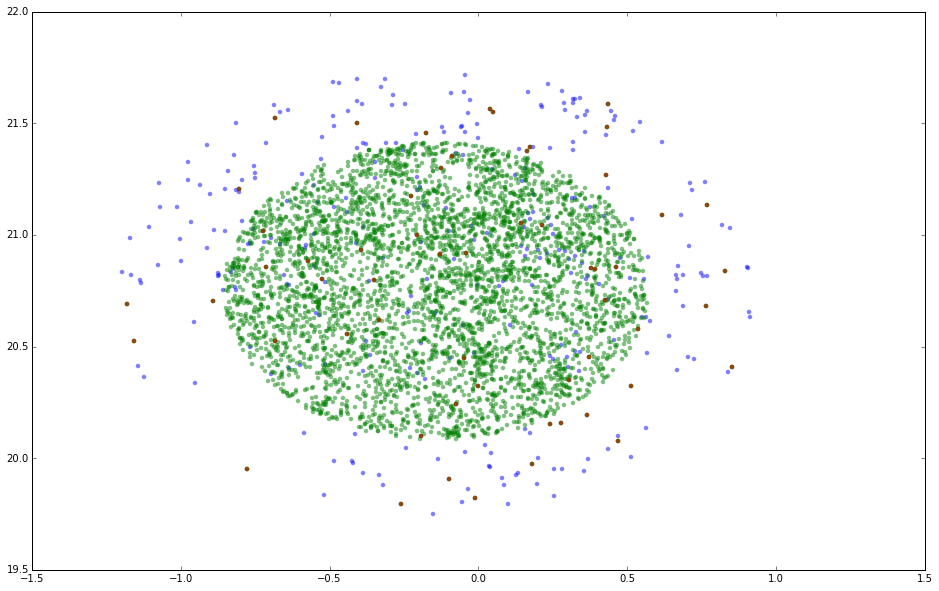

In [132]:
fncat = 'mmthecto/NSA153017_nov2015_fixed180.cat'
fnflux = 'mmthecto/NSA153017_nov2015_fixed180.fluxstars'

cat153017 = Table.read(fncat, format='ascii', data_start=2)
flux153017 = Table.read(fnflux, format='ascii')

catra = Angle(cat153017['ra'], u.hour).to(u.deg)
catdec = Angle(cat153017['dec'], u.deg)
fluxra = Angle(flux153017['RA'], u.deg)
fluxdec = Angle(flux153017['DEC'], u.deg)

msk = cat153017['type']=='guide'

plt.scatter(catra[msk], catdec[msk], alpha=.5,lw=0)
plt.scatter(catra[~msk], catdec[~msk], alpha=.5,lw=0, c='g')
plt.scatter(fluxra, fluxdec, alpha=.5,lw=0, c='r')